#### CS Assignment: Predicting the number of pitstops in an F1 race given initial conditions

In [ ]:
!python --version

Python 3.10.12


In [ ]:
pip install --upgrade category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.4 MB/s eta 0:00:00


In [ ]:
# Packages

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from category_encoders import OrdinalEncoder
from google.colab import files
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# 1.0 Data pre-processing


In [ ]:
# Load the dataset containing race information

uploaded = files.upload()

Saving Clustering data.xlsx to Clustering data.xlsx


In [ ]:
# Releases · f1db/f1db (github.com) load the dependent variable, the grid position and the end position

y = pd.read_excel("Clustering data.xlsx")
y.head(5), y.columns

(   year  round  driverNumber         driverId  positionNumber  \
 0  2022      1            16  charles-leclerc               1   
 1  2022      1            55  carlos-sainz-jr               2   
 2  2022      1            44   lewis-hamilton               3   
 3  2022      1            63   george-russell               4   
 4  2022      1            20  kevin-magnussen               5   
 
    gridPositionNumber  pitStops  
 0                   1         3  
 1                   3         3  
 2                   5         3  
 3                   9         3  
 4                   7         3  ,
 Index(['year', 'round', 'driverNumber', 'driverId', 'positionNumber',
        'gridPositionNumber', 'pitStops'],
       dtype='object'))

In [ ]:
# Load weather file

uploaded = files.upload()

Saving Weather 2022-2023.xlsx to Weather 2022-2023.xlsx


In [ ]:
# Load the weather data
# File source: https://www.kaggle.com/datasets/quantumkaze/f1-weather-dataset-2018-2023

temp = pd.read_excel("Weather 2022-2023.xlsx")
temp.head(5)

,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Round Number,Year
0,0 days 00:01:03.204000,25.6,17,1010.2,False,32.3,346,0.5,1,2022
1,0 days 00:02:03.202000,25.7,17,1010.2,False,32.3,347,0.6,1,2022
2,0 days 00:03:03.205000,25.7,17,1010.0,False,32.2,359,0.4,1,2022
3,0 days 00:04:03.220000,25.7,17,1010.2,False,32.2,8,0.4,1,2022
4,0 days 00:05:03.218000,25.6,17,1010.0,False,32.1,16,0.5,1,2022


In [ ]:
# Features in a weather data set

temp.columns

Index(['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed', 'Round Number', 'Year'],
      dtype='object')

In [ ]:
# Take only the weather values at the beginning of the races
temp_initial = temp.groupby(["Year","Round Number"]).first().reset_index()

# Remove least relevant fatures
temp_initial = temp_initial.drop(columns=["Time","Pressure","WindDirection","WindSpeed","Rainfall"])

# Reorder features
temp_initial.head(5)



,Year,Round Number,AirTemp,Humidity,TrackTemp
0,2022,1,25.6,17,32.3
1,2022,2,25.3,64,29.6
2,2022,3,26.0,48,40.6
3,2022,4,11.1,91,17.6
4,2022,5,31.7,49,42.8


In [ ]:
# Merge the race dataset with the wether data set

dataset = y.merge(temp_initial, left_on=["year","round"], right_on=["Year","Round Number"])
dataset.head(5)

,year,round,driverNumber,driverId,positionNumber,gridPositionNumber,pitStops,Year,Round Number,AirTemp,Humidity,TrackTemp
0,2022,1,16,charles-leclerc,1,1,3,2022,1,25.6,17,32.3
1,2022,1,55,carlos-sainz-jr,2,3,3,2022,1,25.6,17,32.3
2,2022,1,44,lewis-hamilton,3,5,3,2022,1,25.6,17,32.3
3,2022,1,63,george-russell,4,9,3,2022,1,25.6,17,32.3
4,2022,1,20,kevin-magnussen,5,7,3,2022,1,25.6,17,32.3


In [ ]:
# Drop year and round columns as they have been duplicated

dataset = dataset.drop(columns=["Year","Round Number"])
dataset.head(5)

,year,round,driverNumber,driverId,positionNumber,gridPositionNumber,pitStops,AirTemp,Humidity,TrackTemp
0,2022,1,16,charles-leclerc,1,1,3,25.6,17,32.3
1,2022,1,55,carlos-sainz-jr,2,3,3,25.6,17,32.3
2,2022,1,44,lewis-hamilton,3,5,3,25.6,17,32.3
3,2022,1,63,george-russell,4,9,3,25.6,17,32.3
4,2022,1,20,kevin-magnussen,5,7,3,25.6,17,32.3


In [ ]:
# Load the corners data
uploaded = files.upload()

Saving Circuit characteristics.xlsx to Circuit characteristics.xlsx


In [ ]:
# Number of corners for each track was manually collected from the official F1 website, while circuitType was obtained from Github dataset

corners = pd.read_excel("Circuit characteristics.xlsx")
corners.head(10)

,year,round,circuitType,Corners
0,2022,1,RACE,15
1,2022,2,STREET,27
2,2022,3,STREET,14
3,2022,4,RACE,19
4,2022,5,STREET,19
5,2022,6,RACE,14
6,2022,7,STREET,19
7,2022,8,STREET,20
8,2022,9,STREET,14
9,2022,10,RACE,18


In [ ]:
# Merge all three data sets

dataset = dataset.merge(corners, left_on=["year","round"], right_on=["year","round"])
dataset.head(20)

,year,round,driverNumber,driverId,positionNumber,gridPositionNumber,pitStops,AirTemp,Humidity,TrackTemp,circuitType,Corners
0,2022,1,16,charles-leclerc,1,1,3,25.6,17,32.3,RACE,15
1,2022,1,55,carlos-sainz-jr,2,3,3,25.6,17,32.3,RACE,15
2,2022,1,44,lewis-hamilton,3,5,3,25.6,17,32.3,RACE,15
3,2022,1,63,george-russell,4,9,3,25.6,17,32.3,RACE,15
4,2022,1,20,kevin-magnussen,5,7,3,25.6,17,32.3,RACE,15
5,2022,1,77,valtteri-bottas,6,6,3,25.6,17,32.3,RACE,15
6,2022,1,31,esteban-ocon,7,11,3,25.6,17,32.3,RACE,15
7,2022,1,22,yuki-tsunoda,8,16,3,25.6,17,32.3,RACE,15
8,2022,1,14,fernando-alonso,9,8,3,25.6,17,32.3,RACE,15
9,2022,1,24,guanyu-zhou,10,15,3,25.6,17,32.3,RACE,15


In [ ]:
# Check if there are any missing values

dataset.isna().sum().sum()

0

In [ ]:
# Load tire data

uploaded = files.upload()

Saving Starting tires.xlsx to Starting tires.xlsx


In [ ]:
#Load the dataset with tire information

tires = pd.read_excel("Starting tires.xlsx")
tires.head(10)

,year,round,driverNumber,driverId,Starting tyre
0,2022,1,16,charles-leclerc,soft
1,2022,1,55,carlos-sainz-jr,soft
2,2022,1,44,lewis-hamilton,soft
3,2022,1,63,george-russell,soft
4,2022,1,20,kevin-magnussen,soft
5,2022,1,77,valtteri-bottas,soft
6,2022,1,31,esteban-ocon,soft
7,2022,1,22,yuki-tsunoda,soft
8,2022,1,14,fernando-alonso,soft
9,2022,1,24,guanyu-zhou,soft


In [ ]:
# Merge all three data sets

dataset = dataset.merge(tires, left_on=["year","round","driverNumber","driverId"], right_on=["year","round","driverNumber","driverId"])
dataset.head(20)

,year,round,driverNumber,driverId,positionNumber,gridPositionNumber,pitStops,AirTemp,Humidity,TrackTemp,circuitType,Corners,Starting tyre
0,2022,1,16,charles-leclerc,1,1,3,25.6,17,32.3,RACE,15,soft
1,2022,1,55,carlos-sainz-jr,2,3,3,25.6,17,32.3,RACE,15,soft
2,2022,1,44,lewis-hamilton,3,5,3,25.6,17,32.3,RACE,15,soft
3,2022,1,63,george-russell,4,9,3,25.6,17,32.3,RACE,15,soft
4,2022,1,20,kevin-magnussen,5,7,3,25.6,17,32.3,RACE,15,soft
5,2022,1,77,valtteri-bottas,6,6,3,25.6,17,32.3,RACE,15,soft
6,2022,1,31,esteban-ocon,7,11,3,25.6,17,32.3,RACE,15,soft
7,2022,1,22,yuki-tsunoda,8,16,3,25.6,17,32.3,RACE,15,soft
8,2022,1,14,fernando-alonso,9,8,3,25.6,17,32.3,RACE,15,soft
9,2022,1,24,guanyu-zhou,10,15,3,25.6,17,32.3,RACE,15,soft


In [ ]:
# Counts of observations and unique races

dataset.shape, dataset[["year","round"]].groupby("year").nunique()

((739, 13),
       round
 year       
 2022     22
 2023     22)

In [ ]:
# Count the number of each value

dataset.pitStops.value_counts().sort_index(ascending=True)

,count
pitStops,
1,226
2,314
3,137
4,41
5,12
6,6
7,3


In [ ]:
dataset.pitStops.describe()

,pitStops
count,739.000000
mean,2.092016
std,1.040991
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,7.000000


<Axes: >

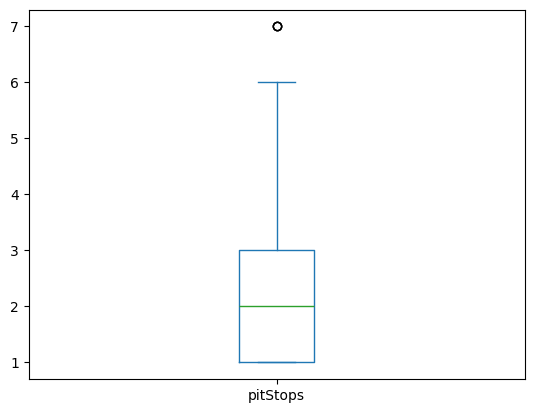

In [ ]:
dataset.pitStops.plot.box(rot=0,)

<function matplotlib.pyplot.show(close=None, block=None)>

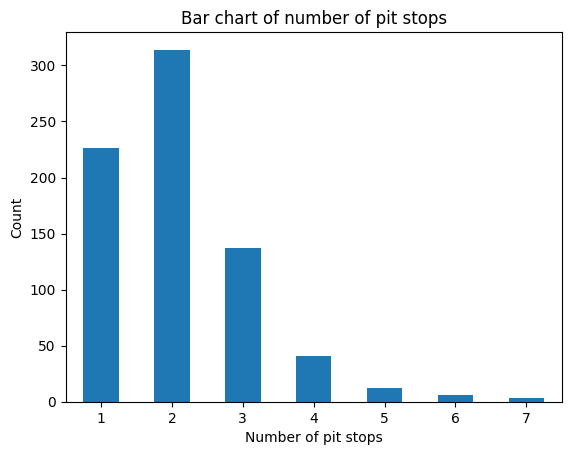

In [ ]:
# Plot the bar chart

plt.title("Bar chart of number of pit stops")
dataset.pitStops.value_counts().sort_index(ascending=True).plot.bar(rot=0)
plt.xlabel('Number of pit stops')
plt.ylabel('Count')
plt.show

In [ ]:
print("Number of rounds someoned has done 7 pitstops:",dataset[dataset["pitStops"]==7][["year","round"]].groupby("year").nunique().sum(),"\n\nNumber of rounds someoned has done 6 pitstops :",
dataset[dataset["pitStops"]==6][["year","round"]].groupby("year").nunique().sum(),"\n\nNumber of rounds someoned has done 5 pitstops:",
dataset[dataset["pitStops"]==5][["year","round"]].groupby("year").nunique().sum(),"\n\nNumber of rounds someoned has done 4 pitstops:",
dataset[dataset["pitStops"]==4][["year","round"]].groupby("year").nunique().sum(),"\n\nNumber of rounds someoned has done 3 pitstops:",
dataset[dataset["pitStops"]==3][["year","round"]].groupby("year").nunique().sum(),"\n\nNumber of rounds someoned has done 2 pitstops:",
dataset[dataset["pitStops"]==2][["year","round"]].groupby("year").nunique().sum(),"\n\nNumber of rounds someoned has done 1 pitstops:",
dataset[dataset["pitStops"]==1][["year","round"]].groupby("year").nunique().sum())

Number of rounds someoned has done 7 pitstops: round    1
dtype: int64 

Number of rounds someoned has done 6 pitstops : round    3
dtype: int64 

Number of rounds someoned has done 5 pitstops: round    5
dtype: int64 

Number of rounds someoned has done 4 pitstops: round    9
dtype: int64 

Number of rounds someoned has done 3 pitstops: round    27
dtype: int64 

Number of rounds someoned has done 2 pitstops: round    38
dtype: int64 

Number of rounds someoned has done 1 pitstops: round    26
dtype: int64


In [ ]:
dataset["Starting tyre"].value_counts()

,count
Starting tyre,
medium,418
soft,186
hard,71
inter,47
wet,17


In [ ]:
# Check in how many tires each compound was used


print("Number of rounds wet tires were used in:",dataset[dataset["Starting tyre"]=="wet"][["year","round"]].groupby("year").nunique().sum(),"\n\nNumber of rounds intern tires were used in:",
dataset[dataset["Starting tyre"]=="inter"][["year","round"]].groupby("year").nunique().sum(),"\n\nNumber of rounds hard tires were used in:",
dataset[dataset["Starting tyre"]=="hard"][["year","round"]].groupby("year").nunique().sum(),"\n\nNumber of rounds soft tires were used in:",
dataset[dataset["Starting tyre"]=="soft"][["year","round"]].groupby("year").nunique().sum(),"\n\nNumber of rounds medium tires were used in:",
dataset[dataset["Starting tyre"]=="medium"][["year","round"]].groupby("year").nunique().sum())

# Despite hard tire not having many more observations than intern tire, they are used in a lot more races

Number of rounds wet tires were used in: round    1
dtype: int64 

Number of rounds intern tires were used in: round    3
dtype: int64 

Number of rounds hard tires were used in: round    25
dtype: int64 

Number of rounds soft tires were used in: round    28
dtype: int64 

Number of rounds medium tires were used in: round    39
dtype: int64


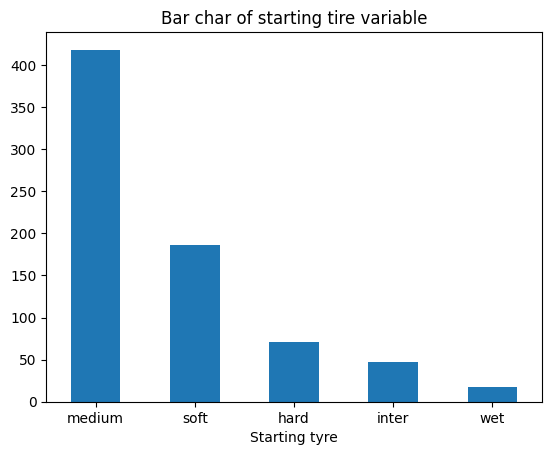

In [ ]:
# Count and plot the tire count
plt.title("Bar char of starting tire variable")
dataset["Starting tyre"].value_counts(), dataset["Starting tyre"].value_counts().plot.bar(rot=0)
plt.show()

In [ ]:
# Remove entries with any other tire apart from soft, medium and hard

dataset = dataset[(dataset["Starting tyre"] == "soft")|(dataset["Starting tyre"] == "medium")|(dataset["Starting tyre"] == "hard")]
dataset.shape

(675, 13)

In [ ]:
#Remove the entries with 5 or more pitstops as we have labelled them as outliers

dataset = dataset[(dataset["pitStops"] < 5)]

In [ ]:
dataset.shape

(654, 13)

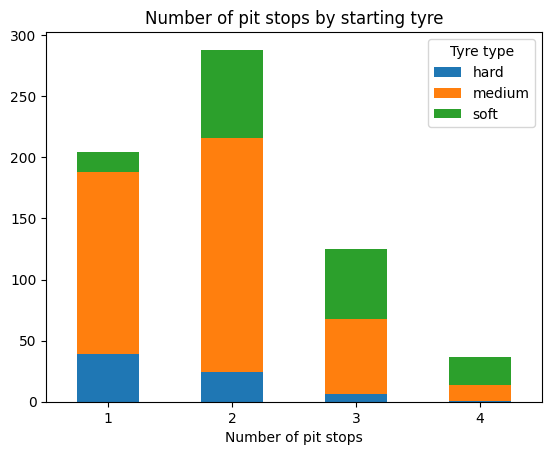

In [ ]:
# Two way bar chart of pitstops and tyres

stops_by_tyres = dataset.groupby(['pitStops','Starting tyre']).size().unstack(fill_value=0)
stops_by_tyres.plot(kind='bar', stacked=True, rot=0)
plt.title('Number of pit stops by starting tyre')
plt.xlabel('Number of pit stops')
plt.legend(title='Tyre type')
plt.show()

In [ ]:
dataset

,year,round,driverNumber,driverId,positionNumber,gridPositionNumber,pitStops,AirTemp,Humidity,TrackTemp,circuitType,Corners,Starting tyre
0,2022,1,16,charles-leclerc,1,1,3,25.6,17,32.3,RACE,15,soft
1,2022,1,55,carlos-sainz-jr,2,3,3,25.6,17,32.3,RACE,15,soft
2,2022,1,44,lewis-hamilton,3,5,3,25.6,17,32.3,RACE,15,soft
3,2022,1,63,george-russell,4,9,3,25.6,17,32.3,RACE,15,soft
4,2022,1,20,kevin-magnussen,5,7,3,25.6,17,32.3,RACE,15,soft
...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,2023,22,2,logan-sargeant,16,20,2,27.7,49,38.2,RACE,16,medium
735,2023,22,24,guanyu-zhou,17,19,2,27.7,49,38.2,RACE,16,medium
736,2023,22,55,carlos-sainz-jr,18,16,2,27.7,49,38.2,RACE,16,hard
737,2023,22,77,valtteri-bottas,19,18,1,27.7,49,38.2,RACE,16,hard


(<Figure size 640x480 with 3 Axes>,
 {('3', 'soft'): (0.0, 0.0, 0.18830689504526896, 0.4529801324503311),
  ('3', 'medium'): (0.0,
   0.4562913907284768,
   0.18830689504526896,
   0.49271523178807936),
  ('3', 'hard'): (0.0,
   0.9523178807947018,
   0.18830689504526896,
   0.04768211920529805),
  ('2', 'soft'): (0.1932330034196532,
   0.0,
   0.4338590861842997,
   0.24834437086092712),
  ('2', 'medium'): (0.1932330034196532,
   0.25165562913907286,
   0.4338590861842997,
   0.6622516556291389),
  ('2', 'hard'): (0.1932330034196532,
   0.9172185430463575,
   0.4338590861842997,
   0.0827814569536424),
  ('1', 'soft'): (0.6320181979783371,
   0.0,
   0.30731685271387893,
   0.07791195948578106),
  ('1', 'medium'): (0.6320181979783371,
   0.08122321776392674,
   0.30731685271387893,
   0.7255551227113362),
  ('1', 'hard'): (0.6320181979783371,
   0.8100895987534086,
   0.30731685271387893,
   0.1899104012465913),
  ('4', 'soft'): (0.9442611590666004,
   0.0,
   0.05573884093339957,
   

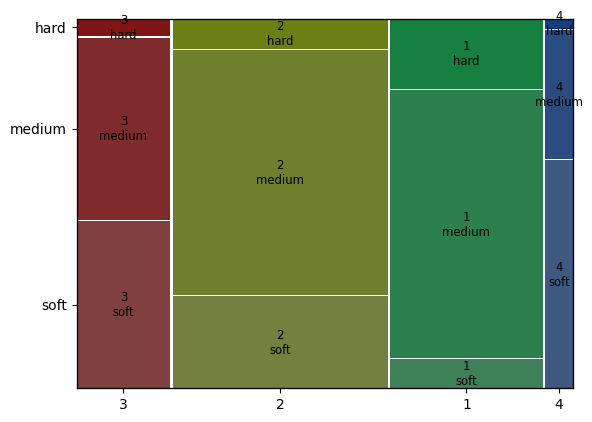

In [ ]:
# Mosaic plot
mosaic(dataset, ['pitStops', 'Starting tyre'],labelizer=None,axes_label=True)

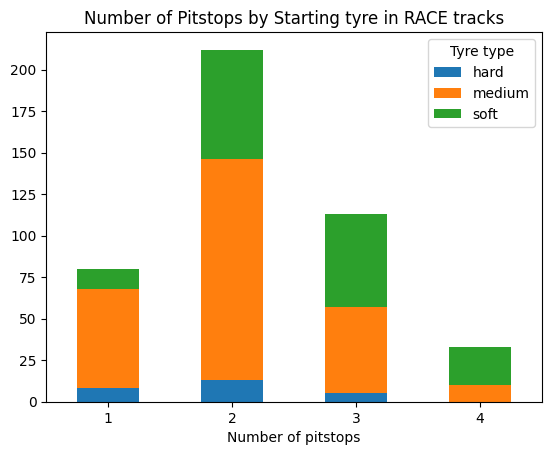

In [ ]:
# Same plot for RACES only

stops_by_tyres = dataset[dataset["circuitType"]=="RACE"].groupby(['pitStops','Starting tyre']).size().unstack(fill_value=0)
stops_by_tyres.plot(kind='bar', stacked=True, rot=0)
plt.title('Number of Pitstops by Starting tyre in RACE tracks')
plt.xlabel('Number of pitstops')
plt.legend(title='Tyre type')
plt.show()

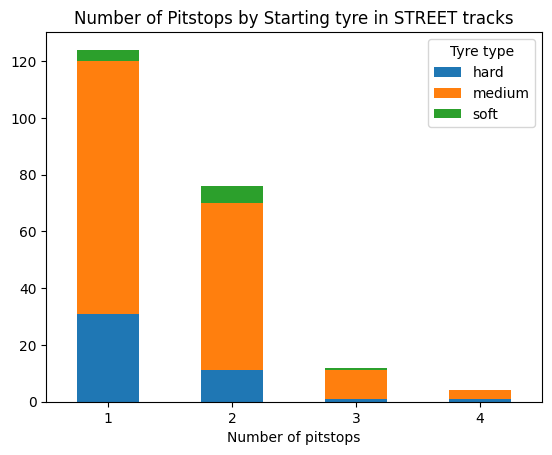

In [ ]:
# Same plot for STREET tracks only

stops_by_tyres = dataset[dataset["circuitType"]=="STREET"].groupby(['pitStops','Starting tyre']).size().unstack(fill_value=0)
stops_by_tyres.plot(kind='bar', stacked=True, rot=0)
plt.title('Number of Pitstops by Starting tyre in STREET tracks')
plt.xlabel('Number of pitstops')
plt.legend(title='Tyre type')
plt.show()

In [ ]:
# Summary pitstops statistics per each track type

dataset[["pitStops","circuitType"]].groupby("circuitType").describe()

pitStops                                             
               count      mean       std  min  25%  50%  75%  max
circuitType                                                      
RACE           438.0  2.226027  0.832167  1.0  2.0  2.0  3.0  4.0
STREET         216.0  1.518519  0.688530  1.0  1.0  1.0  2.0  4.0

## Explore the dependet variable

In [ ]:
# Create a dataset where categorical variables are converted to numerical

dataset_noCat = OrdinalEncoder(cols=["Starting tyre"]).fit_transform(dataset)
# In tire data, 1 = soft, 2 = medium, 3 = hard

dataset_noCat = OrdinalEncoder(cols=["circuitType"]).fit_transform(dataset_noCat )
# In circuit data, 1 = Race, 2 = Street
dataset_noCat

# I left (dataset) unchanged, so it can be used for analysis and plotting (if we wantn to use labels)

,year,round,driverNumber,driverId,positionNumber,gridPositionNumber,pitStops,AirTemp,Humidity,TrackTemp,circuitType,Corners,Starting tyre
0,2022,1,16,charles-leclerc,1,1,3,25.6,17,32.3,1,15,1
1,2022,1,55,carlos-sainz-jr,2,3,3,25.6,17,32.3,1,15,1
2,2022,1,44,lewis-hamilton,3,5,3,25.6,17,32.3,1,15,1
3,2022,1,63,george-russell,4,9,3,25.6,17,32.3,1,15,1
4,2022,1,20,kevin-magnussen,5,7,3,25.6,17,32.3,1,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,2023,22,2,logan-sargeant,16,20,2,27.7,49,38.2,1,16,2
735,2023,22,24,guanyu-zhou,17,19,2,27.7,49,38.2,1,16,2
736,2023,22,55,carlos-sainz-jr,18,16,2,27.7,49,38.2,1,16,3
737,2023,22,77,valtteri-bottas,19,18,1,27.7,49,38.2,1,16,3


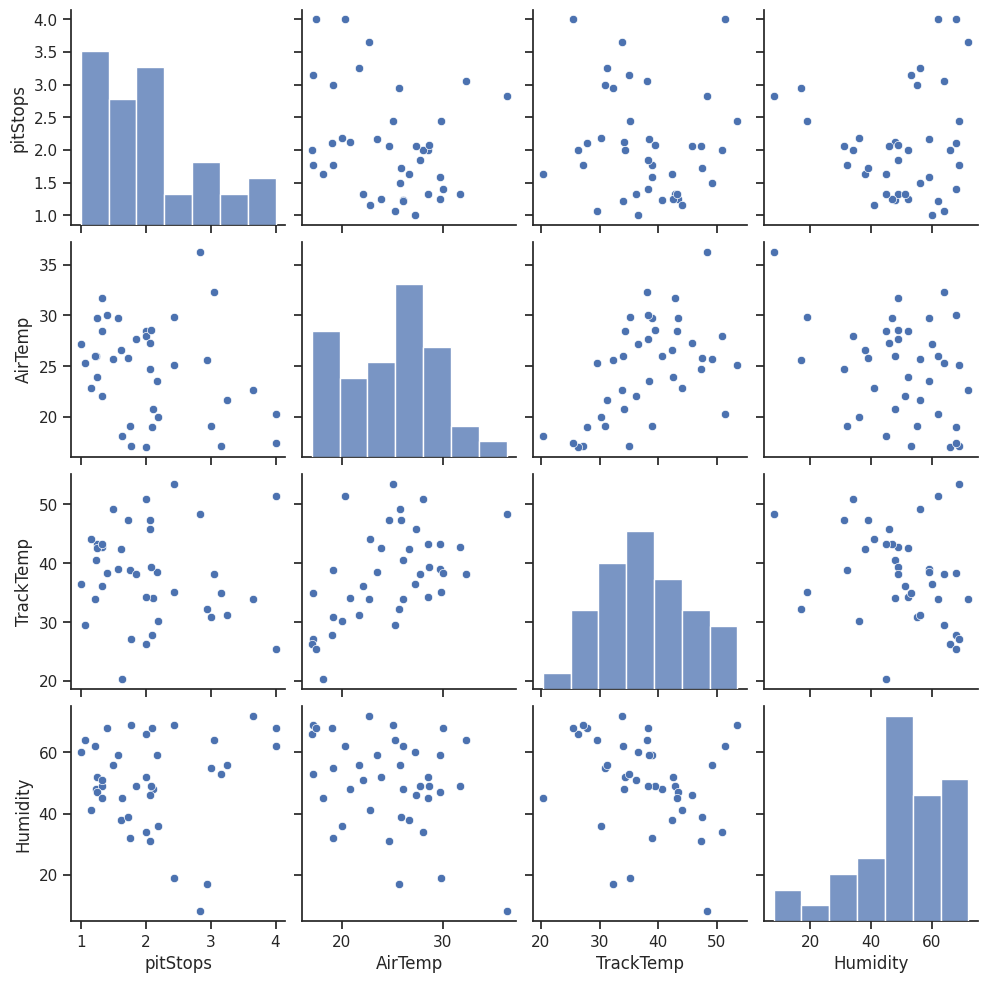

In [ ]:
# Do a scatterplot with all continous variables

sns.set_theme(style="ticks")
sns.pairplot(dataset_noCat[["year","round","pitStops","AirTemp","TrackTemp","Humidity"]].groupby(["year","round"]).mean())

# 1.1 Start of analysis

In [ ]:
dataset_noCat.columns

Index(['year', 'round', 'driverNumber', 'driverId', 'positionNumber',
       'gridPositionNumber', 'pitStops', 'AirTemp', 'Humidity', 'TrackTemp',
       'circuitType', 'Corners', 'Starting tyre'],
      dtype='object')

In [ ]:
dataset_noCat.columns

Index(['year', 'round', 'driverNumber', 'driverId', 'positionNumber',
       'gridPositionNumber', 'pitStops', 'AirTemp', 'Humidity', 'TrackTemp',
       'circuitType', 'Corners', 'Starting tyre'],
      dtype='object')

In [ ]:
dataset_noCat = dataset_noCat.iloc[:,[0,1,2,3,4,6,5,7,8,9,10,11,12]]

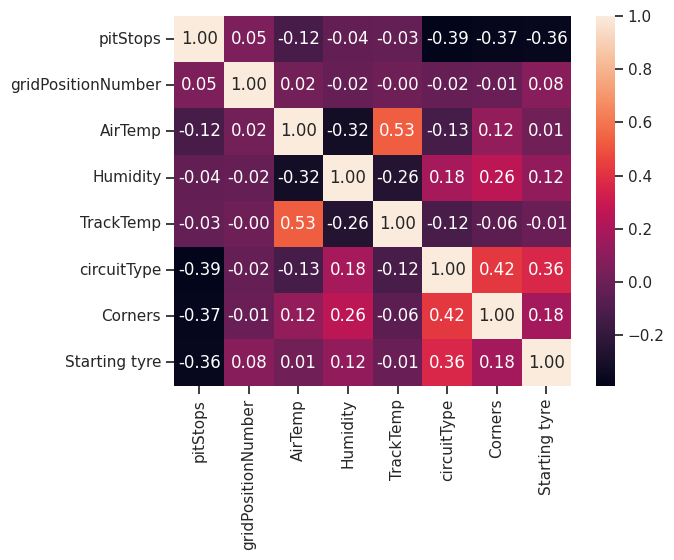

In [ ]:
corr = dataset_noCat.drop(columns=["year","round","driverNumber","driverId","positionNumber"]).corr()
sns.heatmap(corr,annot=True,fmt=".2f")
plt.show()

In [ ]:
# Create data with idfferent combination of feature variables

x3 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops","positionNumber","AirTemp",]) # With track temp
x2 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops","positionNumber","TrackTemp",]) # With air temp
x1 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops","positionNumber"])  # with both temperatures, humidity and grid
x4 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops","positionNumber","AirTemp","TrackTemp"])

x5 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops","positionNumber","Humidity"]) # Without humidity
x6 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops","positionNumber","Humidity","TrackTemp"])
x7 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops","positionNumber","Humidity","AirTemp"]) # Without humidity and air temp
x8 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops","positionNumber","Humidity","AirTemp","TrackTemp"]) # Without humidity and air temp

x10 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops",'gridPositionNumber',"positionNumber","AirTemp",]) # With track temp
x11 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops", 'gridPositionNumber',"positionNumber","TrackTemp",]) # With air temp
x9 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops", 'gridPositionNumber',"positionNumber"])  # with both temperatures, humidity and grid
x12 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops", 'gridPositionNumber',"positionNumber","AirTemp","TrackTemp"])

x13 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops", 'gridPositionNumber',"positionNumber","Humidity"]) # Without humidity
x14 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops", 'gridPositionNumber',"positionNumber","Humidity","TrackTemp"])
x15 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops", 'gridPositionNumber',"positionNumber","Humidity","AirTemp"]) # Without humidity and air temp
x16 = dataset_noCat.drop(columns = ["year","round","driverNumber","driverId","pitStops", 'gridPositionNumber',"positionNumber","Humidity","AirTemp","TrackTemp"]) # Without humidity and air temp

y = dataset_noCat.pitStops

In [ ]:
# Create training and tesing data for different combination of feature variables

x_train1, x_test1, y_train1, y_test1 = train_test_split(
    x1, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train2, x_test2, y_train2, y_test2 = train_test_split(
    x2, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train3, x_test3, y_train3, y_test3 = train_test_split(
    x3, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train4, x_test4, y_train4, y_test4 = train_test_split(
    x4, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train5, x_test5, y_train5, y_test5 = train_test_split(
    x5, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train6, x_test6, y_train6, y_test6 = train_test_split(
    x6, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train7, x_test7, y_train7, y_test7 = train_test_split(
    x7, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train8, x_test8, y_train8, y_test8 = train_test_split(
    x8, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train9, x_test9, y_train9, y_test9 = train_test_split(
    x9, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train10, x_test10, y_train10, y_test10 = train_test_split(
    x10, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train11, x_test11, y_train11, y_test11 = train_test_split(
    x11, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train12, x_test12, y_train12, y_test12 = train_test_split(
    x12, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train13, x_test13, y_train13, y_test13 = train_test_split(
    x13, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train14, x_test14, y_train14, y_test14 = train_test_split(
    x14, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train15, x_test15, y_train15, y_test15 = train_test_split(
    x15, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state
x_train16, x_test16, y_train16, y_test16 = train_test_split(
    x16, y, test_size=0.3, random_state=202469752) # The random state is my registration number, I always use it for the random state


In [ ]:
# Implement minimum the minimum number of observations at a node

def fun(x_train1, y_train1,x_test1, y_test1)->None:
       a = 0
       b = 0
       for i in range(20):
         model = tree.DecisionTreeClassifier(min_samples_leaf=i+1)
         model = model.fit(x_train1, y_train1)
         if model.score(x_test1, y_test1)>a:
             a = model.score(x_test1, y_test1)
             b = i
       print(a,b)

fun(x_train1, y_train1,x_test1, y_test1)
fun(x_train2, y_train2,x_test2, y_test2)
fun(x_train3, y_train3,x_test3, y_test3)
fun(x_train4, y_train4,x_test4, y_test4)
fun(x_train5, y_train5,x_test5, y_test5)
fun(x_train6, y_train6,x_test6, y_test6)
fun(x_train7, y_train7,x_test7, y_test7)
fun(x_train8, y_train8,x_test8, y_test8)
fun(x_train9, y_train9,x_test9, y_test9)
fun(x_train10, y_train10,x_test10, y_test10)
fun(x_train11, y_train11,x_test11, y_test11)
fun(x_train12, y_train12,x_test12, y_test12)
fun(x_train13, y_train13,x_test13, y_test13)
fun(x_train14, y_train14,x_test14, y_test14)
fun(x_train15, y_train15,x_test15, y_test15)
fun(x_train16, y_train16,x_test16, y_test16)

0.7360406091370558 8
0.7461928934010152 9
0.7157360406091371 9
0.6954314720812182 6
0.7157360406091371 6
0.751269035532995 9
0.700507614213198 8
0.5532994923857868 16
0.751269035532995 8
0.7563451776649747 8
0.766497461928934 9
0.7309644670050761 6
0.751269035532995 8
0.7563451776649747 9
0.7360406091370558 8
0.5431472081218274 2


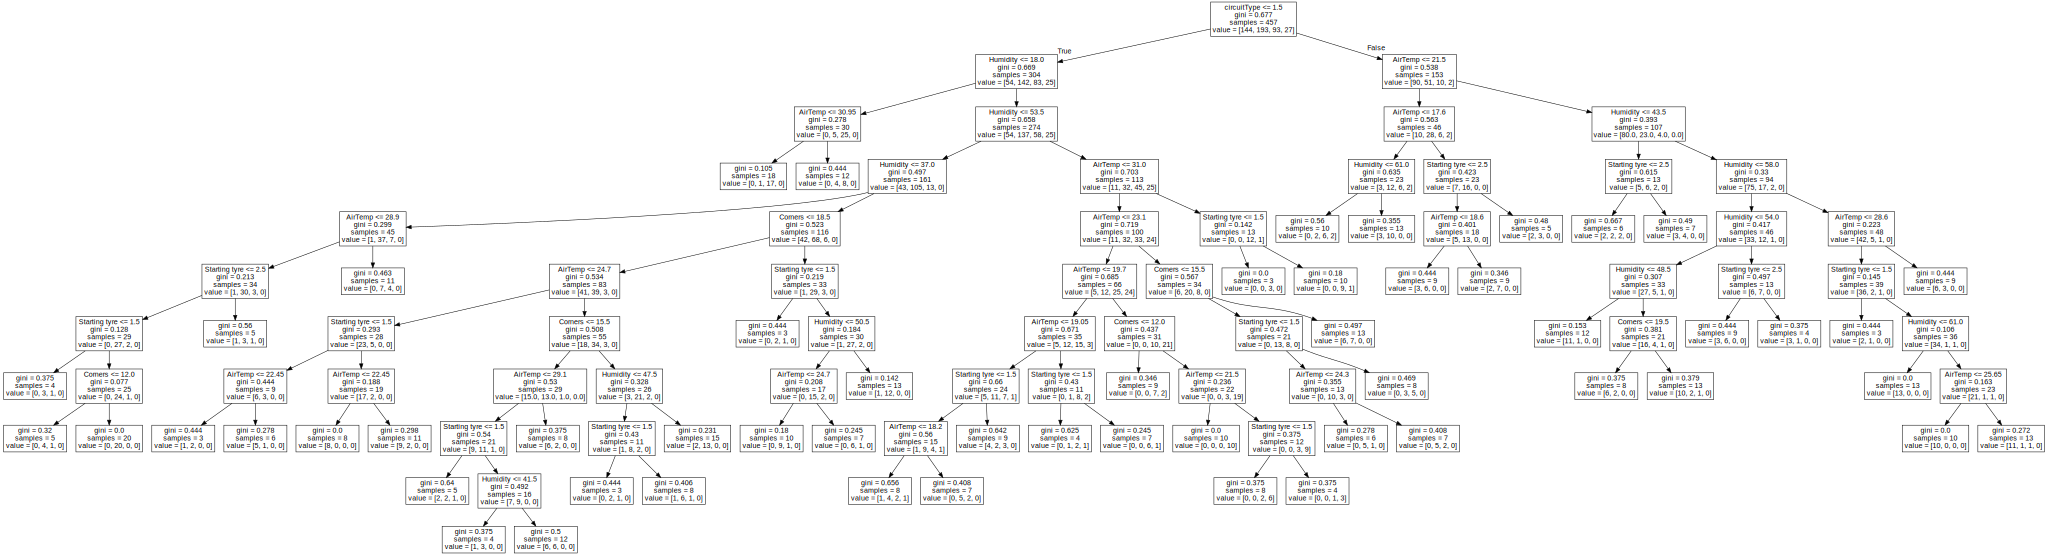

In [ ]:
# Plot the best performing model

import graphviz
model = tree.DecisionTreeClassifier(min_samples_leaf=3)
model = model.fit(x_train11, y_train11)
dot_data = tree.export_graphviz(model, out_file=None,feature_names=x_train11.columns)
graph = graphviz.Source(dot_data)
graph

# 1.2 Hierarchical clustering

In [ ]:
# Check the dataset

dataset_noCat.head(10)

,year,round,driverNumber,driverId,positionNumber,pitStops,gridPositionNumber,AirTemp,Humidity,TrackTemp,circuitType,Corners,Starting tyre
0,2022,1,16,charles-leclerc,1,3,1,25.6,17,32.3,1,15,1
1,2022,1,55,carlos-sainz-jr,2,3,3,25.6,17,32.3,1,15,1
2,2022,1,44,lewis-hamilton,3,3,5,25.6,17,32.3,1,15,1
3,2022,1,63,george-russell,4,3,9,25.6,17,32.3,1,15,1
4,2022,1,20,kevin-magnussen,5,3,7,25.6,17,32.3,1,15,1
5,2022,1,77,valtteri-bottas,6,3,6,25.6,17,32.3,1,15,1
6,2022,1,31,esteban-ocon,7,3,11,25.6,17,32.3,1,15,1
7,2022,1,22,yuki-tsunoda,8,3,16,25.6,17,32.3,1,15,1
8,2022,1,14,fernando-alonso,9,3,8,25.6,17,32.3,1,15,1
9,2022,1,24,guanyu-zhou,10,3,15,25.6,17,32.3,1,15,1


In [ ]:
# Create a dataset for clustering

data_clustering  = dataset_noCat.drop(columns=["year","round","driverId","AirTemp","TrackTemp","Humidity","circuitType","Corners"])

In [ ]:
#Transform the feature variables

scaler = MinMaxScaler()
data_clustering.iloc[:,1:-1]  = scaler.fit_transform(data_clustering.iloc[:,1:-1])

<ipython-input-51-2d41b4f5a199>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 0.         0.05263158 0.10526316 0.15789474 0.21052632
 0.26315789 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579
 0.57894737 0.63157895 0.68421053 0.         0.05263158 0.10526316
 0.15789474 0.21052632 0.26315789 0.31578947 0.36842105 0.42105263
 0.47368421 0.52631579 0.57894737 0.63157895 0.68421053 0.73684211
 0.78947368 0.84210526 0.         0.05263158 0.10526316 0.15789474
 0.21052632 0.26315789 0.31578947 0.36842105 0.42105263 0.52631579
 0.57894737 0.63157895 0.68421053 0.73684211 0.78947368 0.
 0.05263158 0.10526316 0.15789474 0.21052632 0.26315789 0.31578947
 0.36842105 0.42105263 0.47368421 0.52631579 0.5789

In [ ]:
#Average each drivers record

final_cluster_data= data_clustering.groupby(["driverNumber"]).mean()
final_cluster_data

,positionNumber,pitStops,gridPositionNumber,Starting tyre
driverNumber,,,,
1,0.049861,0.359649,0.124654,1.736842
2,0.726974,0.333333,0.832237,1.937500
3,0.563910,0.333333,0.583960,1.857143
4,0.345865,0.342857,0.374436,1.857143
5,0.518219,0.307692,0.676113,1.615385
6,0.803509,0.488889,0.842105,1.733333
10,0.523220,0.294118,0.549536,1.676471
11,0.167464,0.323232,0.303030,1.818182
14,0.323529,0.343137,0.366873,1.941176


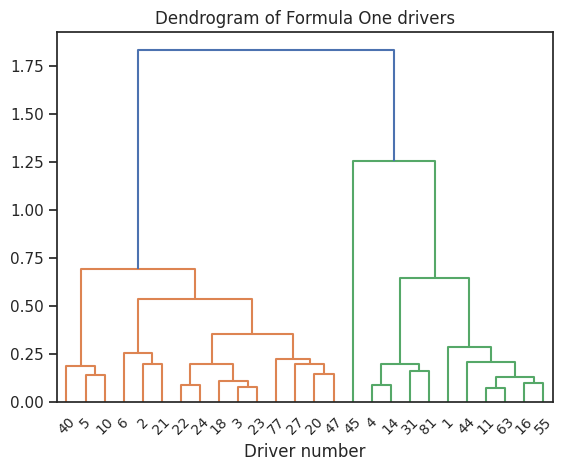

In [ ]:
# Make a hierarchical custering graph (dendrogram)

linkage_data = linkage(final_cluster_data, method='ward', metric='euclidean')
dendrogram(linkage_data, labels = final_cluster_data.index)
plt.title("Dendrogram of Formula One drivers")
plt.xlabel("Driver number")
plt.show()